# Eurofondy na Slovensku

V tomto colabe sme sa pozreli na distribúciu eurofondov z verejnej databázy od verejne.digital. Zaujímalo nás, koľko peňazí putuje na rozvoj jednotlivých sektorov a zároveň aj geografická vizualizácia tejto podpory. Výsledkom sú dve mapy. Prvá vykresľuje výšku dotácií na mape tam, kam peniaze putovali. Druhá ("heatmapa") znázorňuje jednoducho počet vyhratých súťaží o eurofondy v závislosti na lokácii.

*double-clickom na bunku otvorite kód*


In [0]:
#@title Utilitky
import codecs
import collections
import csv
import itertools
import json
import urllib.request
import requests
import numpy as np
import pandas
from collections.abc import Iterable

# Utilitky, ktoré používame na načítanie dát a informácii z API

def _json_from_csv(url, delimiter=",", integer_columns=[]):
    """Loads CSV with header row into JSON format dictionary."""

    result = []
    stream = urllib.request.urlopen(url)
    csvfile = csv.reader(codecs.iterdecode(stream, "utf-8"))
    for ri, row in enumerate(csvfile):
        if ri == 0:
            column_names = tuple(row)
        else:
            assert len(row) == len(column_names)
            try:
                result.append(
                    {key: (int(value) if key in integer_columns else value)
                    for key, value in zip(column_names, row)})
            except ValueError:
                # Catches ValueError when relation has missing eid.
                pass
    print("Loaded %s entries with column names %s from %s" % (
      len(result), column_names, url))
    return result

def _get_api_response(url):
    response = requests.get(url)
    if response.ok:
        data = json.loads(response.content)  
        return data
    else:
        print(response.text)
        return None

# odtiaľto načitavame dáta
# csv_list = ["obstaravania", "contracts", "eurofondy", "entities", "related", "companies", "offices"]
csv_base = "https://verejne.digital/resources/csv/"

# načítavanie kontrétnych databáz
def loadCsv(n, i=[]): return _json_from_csv(csv_base + n + ".csv", integer_columns=i)

# získanie infos na základe eid
def getInfoByEid(s): return _get_api_response("https://verejne.digital/api/v/getInfos?eids={}".format(s if isinstance(s, str) else ",".join(s)))

# pozeráme sa iba na uzavreté zmluvy
call_state_closed = "Uzavretá"

In [78]:
#@title Načítanie dát
# načítame dataset eurofondov 

data_eurofondy = loadCsv("eurofondy")
df_eurofondy = pandas.DataFrame(data_eurofondy)

Loaded 4238 entries with column names ('eid', 'title', 'description', 'link', 'price', 'state', 'call_state', 'call_title') from https://verejne.digital/resources/csv/eurofondy.csv


**Vyberte si oblasť eurofondov, ktorá Vás zaujíma**

*Ak zmeníte výber musíte znova spustiť všetok kód nasledujúci po tejto bunke aby sa vám premietli výsledky na mapách*

*Runtime -> Run After* alebo *Ctrl+F10*

In [0]:
#@title Sektor, ktorý nás zaujíma { run: "auto" }
section = "infrastructure" #@param ["education", "health", "infrastructure"] 

# eurofunds data do not hold info about the category, so we've opted for this option for now.  
section_map = {
    'education': df_eurofondy["title"].str.contains("vzdel") | df_eurofondy["title"].str.contains("škol"),
    'health': df_eurofondy["title"].str.contains("zdrav") | df_eurofondy["title"].str.contains("medic") | df_eurofondy["title"].str.contains("nemoc"),
    'infrastructure': df_eurofondy["title"].str.contains("infraš") | df_eurofondy["title"].str.contains("doprav") | df_eurofondy["title"].str.contains("auto") | df_eurofondy["title"].str.contains("cest") | df_eurofondy["title"].str.contains("vlak")
}

selected_section_data = df_eurofondy[section_map[section]]
# selected_section_data = selected_section_data[selected_section_data["call_state"] == call_state_closed]

eid_list = list(selected_section_data["eid"])
curr, slice_size, total, i = 0, 49, len(eid_list), 0
eid_to_info = {}

while i * slice_size < total:
  lower, upper = i * slice_size, (i+1) * slice_size if (i+1) * slice_size < total else total
  resp = getInfoByEid(filter(None, eid_list[lower:upper]))
  eid_to_info.update(resp)
  i += 1

# z informácií, ktoré sme získali vyberieme adresu a súradnice a priradíme ich do riadkov s im príslušným eid 

selected_section_data = selected_section_data[['eid', 'title', 'description', 'price']].replace(r'^\s*$', np.nan, regex=True).dropna(subset=['eid']).reset_index(drop=True)
for field in ['address', 'lat', 'lng']:
  selected_section_data[field] = selected_section_data['eid'].apply(lambda x: eid_to_info[x][field])

selected_section_data[['price', 'lat', 'lng']] = selected_section_data[['price', 'lat', 'lng']].astype(float)

# Plotovanie polohy na mapu



In [0]:
# !pip3 install geopandas
#!apt-get install -qq libgdal-dev libproj-dev
# !pip3 install geoplot
# !conda install geoplot
# !pip3 install mpld3

import geoplot as gplt
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geoplot.crs as gcrs
import mapclassify as mc
import geopandas as gpd
import mpld3

map_path = 'https://raw.githubusercontent.com/4b1dden/eurofunds_slovakia/master/gadm36_SVK.gpkg'
slovakia = gpd.read_file(map_path)

# zo súradníc vytvoríme geometriu bodov, ktoré zobrazujú polohu
eufunds_points = selected_section_data.apply(
    lambda srs: Point(float(srs['lng']), float(srs['lat'])),
    axis='columns'
)

eurofondy_geocoded = gpd.GeoDataFrame(selected_section_data, geometry=eufunds_points)


In [0]:
#@title Fix na crashovanie kernelu 
#@markdown Zbehnite túto bunku raz po nainštalovaní knižníc a reštartujte Runtime (*Ctrl+M*)


# odkomentujte príkazy a zbehnite

#!pip3 uninstall shapely cartopy --yes
#!pip3 install shapely cartopy --no-binary shapely --no-binary cartopy

In [0]:
slovakia_default_projection = gcrs.AlbersEqualArea(central_latitude=48.6737532, central_longitude=19.696058)

def getSlovakiaAxes():
  return gplt.polyplot(
    slovakia, 
    projection=slovakia_default_projection,
    edgecolor='white', facecolor='lightgray',
    figsize=(12, 8)
  )

# Mapy

Táto mapa vykresľuje distribúciu eurofondov pre vyššie zvolený sektor. Jednotlivé body na mape ukazujú, kam eurofondy putovali. Polomer bodov reprezentuje hodnotu dotácie. Je zaujímavé sledovať, ako sa táto distribúcia mení v závislosti na sektore, ktorý je analyzovaný. Môžeme pekne vidieť, kde peniaze putujú a prečo.

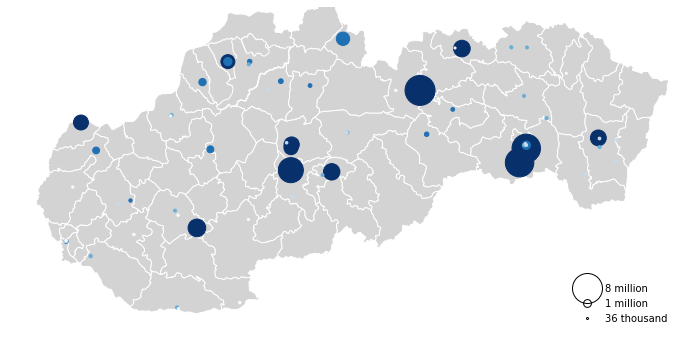

In [177]:
#@title Mapa eurofondov
upper_cap, lower_cap = selected_section_data["price"].astype(int).max(), selected_section_data["price"].astype(int).min()
upper_quantile = selected_section_data["price"].quantile(0.75).astype(int)
scheme = mc.Quantiles(eurofondy_geocoded['price'], k=5)

def getBase(x, e):
  return x // 10**e

def quantile_interpreter(upper_quantile): return len(str(upper_quantile)) < 7

plt = gplt.pointplot(
    eurofondy_geocoded,
    scale='price',
    limits=(2, 30),
    hue='price',
    cmap='Blues',
    scheme=scheme,
    legend=True,
    legend_var='scale',
    legend_values=[upper_cap, upper_quantile, lower_cap],
    legend_labels=['{} million'.format(getBase(upper_cap, 6)), '{} {}'.format(
        getBase(upper_quantile, 3 if quantile_interpreter(upper_quantile) else 6),
        "thousand" if quantile_interpreter(upper_quantile) else "million" 
        ), '{} thousand'.format(getBase(lower_cap, 3))],
    legend_kwargs={'frameon': False, 'loc': 'lower right'},
    ax=getSlovakiaAxes()
)

# Táto mapa zobraje polohu miest kam išli dotácie z eurofondov v danej oblasti
# Veľkosť jednotlivých bodov závisí od veľkosti dotácie rovnako ako aj "tmavosť" farby
# V pravom dolnom rohu je legenda pre ilustráciu veľkosti dotácie

Nižšie sa nachádza heatmapa distribúcie eurofondov. Berie v ohľad iba lokácie, kam eurofondy šli a nie ich hodnoty. Môžeme vidieť, že početne najviac súťaží vyhrávajú práve subjekty na východnom Slovensku.

Táto vizualizácia pekne poskytuje prehľad o tom, kde sú jednotlivé sektory najviac vyťažované. Zatiaľčo peniaze na infraštruktúru idú hlavne do vertikálneho "stredu" Slovenska - predpokladáme, že na diaľnice a cestné komunikácie - zdravotnícke inštitúcie a nemocnice majú svoje geocentrá pri veľkých mestách, čo aj jasne naznačuje ich distribúcia na základe eurofondov. Nakoniec peniaze putujúce do školstva a vzdelávania končia znova hlavne na východnom Slovensku - snáď tam, kde ich je najviac potreba. 

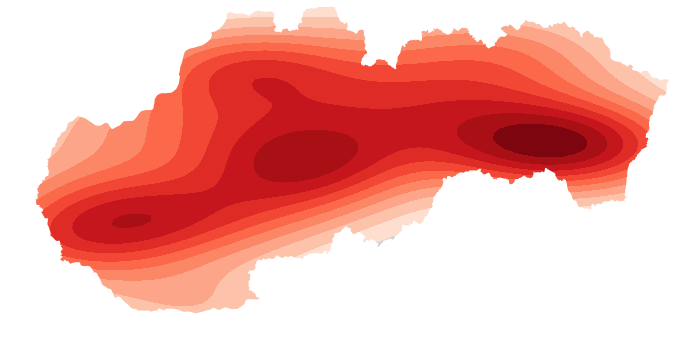

In [178]:
#@title Heatmapa distribúcie

gplt.kdeplot(
    eurofondy_geocoded['geometry'],
    ax=getSlovakiaAxes(),
    cmap='Reds', 
    clip=slovakia.geometry, 
    shade=True, 
  )

# Táto mapa je uvedená ako bonusová z toho dôvodu, že nezávisí od veľkosti dotácií
# Ilustruje však hustotu počtu dotácií v jednotlivých oblastiach 

In [0]:
url_2014_fit = 'https://raw.githubusercontent.com/richard-hamerlik/data/master/Starostovia%202014-2018%20fit.csv'
url_2014 = 'https://raw.githubusercontent.com/richard-hamerlik/data/master/Starostovia%202014-2016.csv'
url_2018_fit = 'https://raw.githubusercontent.com/richard-hamerlik/data/master/Starostovia%202018-2020%20fit.csv'

starostovia_2018 = pandas.read_csv(url_2018)
starostovia_2014 = pandas.read_csv(url_2014)

# starostovia_2014_gps = pandas.merge(starostovia_2014, gps_obiec[['latitude',	'longitude']], on=gps_obiec.index).drop('key_0', 1)
# starostovia_2018_gps = pandas.merge(starostovia_2018, gps_obiec[['latitude',	'longitude']], on=gps_obiec.index).drop('key_0', 1)

In [186]:
import re

mesto_to_starosta_data = {}
for _, obj in starostovia_2014.iterrows():
  mesto_to_starosta_data[obj["Obec, mesto, mestská časť"]] = obj
  #as data is from two unrelated sources, we need a bit of manipulation
  if "-" in obj["Obec, mesto, mestská časť"]:
    mesto_to_starosta_data[obj["Obec, mesto, mestská časť"].split("-")[1]] = obj


def adressStripper(x):
  return x.split(",")[-2] if "," in x else x

selected_section_data['mesto'] = selected_section_data['address'].apply(lambda ad: re.sub(r'[0-9]+', '', adressStripper(ad)))

data_transformation = {
    "name": "Meno a priezvisko",
    "party": "Skratka politického subjektu",
}

def mestoMapper(mesto, field):
  mesto = mesto.strip()

  try:
    data = mesto_to_starosta_data[mesto]
  except KeyError:
    # some towns do have counties, such as Vrable-Whatever, but the major is for Vrable only
    try:
      data = mesto_to_starosta_data[mesto.split("-")[0]]
    except KeyError:
      # too quirky
      return "N/A"

  return data[field]


for key in data_transformation.keys():
  selected_section_data['starosta_{}'.format(key)] = selected_section_data['mesto'].apply(lambda mesto: mestoMapper(mesto, data_transformation[key]))
  # FOKUS A PRECIZIA

# selected_section_data['starosta_party'] = selected_section_data['starosta_party'].apply(lambda party: party.split(","))
selected_section_data

,eid,title,description,price,address,lat,lng,geometry,mesto,starosta_name,starosta_party
0,206226,Zvýšenie produktivity a efektívnosti Nemocnice...,Hlavným cieľom projektu je zabezpečenie modern...,8685573.77,"Banícka 803/28, 058 01 Poprad, Slovakia",49.051780,20.303412,POINT (20.30341 49.05178),Poprad,Jozef Švagerko,"KDH, OBYČAJNÍ ĽUDIA a nezávislé osobnosti, SDK..."
1,302563,Podpora Priemyselného výskumno-vývojového cent...,Projekt je zameraný na budovanie priemyselného...,8227919.60,"Vstupný areál U. S. Steel, 044 54 Košice-Šaca,...",48.619026,21.198826,POINT (21.19883 48.61903),Košice-Šaca,Daniel Petrík,SDKÚ-DS
2,302518,MASYKO – modulárny automatizovaný systém kontr...,MASYKO – Modulárny Automatizovaný SYstém KOntr...,8210815.87,"Južná trieda 1585/95, 040 01 Košice, Slovakia",48.702830,21.261289,POINT (21.26129 48.70283),Košice,Richard Raši,SMER-SD
3,139568,Modernizácia infraštruktúry pre zefektívnenie ...,Cieľom predkladaného projektu je vybudovanie u...,7164152.18,"Kuzmányho nábrežie 28, 960 01 Zvolen, Slovakia",48.580607,19.132171,POINT (19.13217 48.58061),Zvolen,Lenka Balkovičová,NEKA
4,302074,Univerzálny virtuálny inteligentný priestor pr...,Výskumný zámer je zameraný na vytvorenie systé...,5524168.84,"J. Jesenského 1054/44, 960 01 Zvolen, Slovakia",48.574176,19.143000,POINT (19.14300 48.57418),Zvolen,Lenka Balkovičová,NEKA
...,...,...,...,...,...,...,...,...,...,...,...
62,1156572,Na ceste k lepším výsledkom,Základný cieľ projektu je prostredníctvom novo...,82980.00,"Bátovce 368, 935 03 Bátovce, Slovakia",48.287827,18.752409,POINT (18.75241 48.28783),Bátovce,Peter Burčo,"SMER-SD, SNS"
63,2268361,"""Inkluzívna cesta"" Základnej školy s Materskou...",Cieľom žiadateľa ZŠ s MŠ v obci Hniezdne je v ...,62280.00,"Hniezdne 244, 065 01 Hniezdne, Slovakia",49.301229,20.624988,POINT (20.62499 49.30123),Hniezdne,Viktor Selep,SMER-SD
64,1181610,Spoločná cesta k novému domovu,Cieľom projektu je prostredníctvom cezhranične...,52197.50,"Hviezdoslavova 140/1, 911 01 Trenčín, Slovakia",48.893509,18.040354,POINT (18.04035 48.89351),Trenčín,Richard Rybníček,NEKA
65,1280842,Rozšírenie IBV v obci Spišský Štvrtok - lokali...,Obec Spišský Štvrtok územne patrí do Prešovské...,38161.16,"Tatranská 260/4, 053 14 Spišský Štvrtok, Slovakia",49.002831,20.465083,POINT (20.46508 49.00283),Spišský Štvrtok,Ján Greš,NEKA


In [181]:
""

''